## Import packages


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

!pip install cmasher
!pip install torchmetrics

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 4.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 35.1 MB/s eta 0:00:00


'cuda'

## Configuration for training

In [ ]:
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    run_name = 'MHD_CRTransport_FullPwr_twoClasses_newData'
    data_presplit = True # whether data has already been split into training, val, test
    #fileDirArr = ['MHD_beta10', 'CR_Advect_beta10', 'CR_Diff_Fiducial_beta10', 'CR_Diff100_beta10']
    fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    killPwr = False
    num_classes = 2
    train_frac = 0.6
    batch_size = 64
    epochs = 20
    stop_early = True
    patience = 5
    run_locally = False # if running on my computer, take files from local directory instead of downloading them

config = TrainingConfig()

In [ ]:
# Download the relevant data from Google Drive
!pip install --upgrade gdown
import gdown

if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
      #gdown.download(url,output=fileDirArr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Retrieving folder list


Retrieving folder 1-VzRqdBRYTZCEQUtBp6SQzbCI6Yyrp8O CR_Advect_beta10
Processing file 19tRqh3_If4UHpccTOpZU9ZivfBNWBsoS data_CR_Advect_beta10_density_noAugment.npy
Processing file 1YA8yJjwUW39s_eRia-MD5GrinhqQeB5W test_CR_Advect_beta10_density_noAugment.npy
Processing file 1J3GXWfzXxqM_Zx-Ds-fA3WPKICFYKsGG train_CR_Advect_beta10_density_noAugment.npy
Processing file 1-BLfCuVbKlv0FS6CwMMQEVke93avu_1X val_CR_Advect_beta10_density_noAugment.npy
Retrieving folder 1-IsIV2A1J0H2e5lP_JAPUVK1oFWsULca CR_Diff_Fiducial_beta10
Processing file 1EvtNn4GAg4HJhjPldXaiCOUy7T7Le6VO data_CR_Diff_Fiducial_beta10_density_noAugment.npy
Processing file 1ij-MxwrPewtNyWw_aURV8ZTkFTw4Mu2n test_CR_Diff_Fiducial_beta10_density_noAugment.npy
Processing file 1ObbK--x-JqrAZV1SmD44ge1QkWgTXNM2 train_CR_Diff_Fiducial_beta10_density_noAugment.npy
Processing file 1m2otW5aopiKlOYgYaAFts-7c3YQVdCB7 val_CR_Diff_Fiducial_beta10_density_noAugment.npy
Retrieving folder 1wmUveYSrsQzTlUUd3Vdx3yoKHVyRYhcr CR_Diff100_beta10
Proce

Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=19tRqh3_If4UHpccTOpZU9ZivfBNWBsoS
To: /content/Full_Power/CR_Advect_beta10/data_CR_Advect_beta10_density_noAugment.npy
100%|██████████| 1.07G/1.07G [00:05<00:00, 179MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YA8yJjwUW39s_eRia-MD5GrinhqQeB5W
To: /content/Full_Power/CR_Advect_beta10/test_CR_Advect_beta10_density_noAugment.npy
100%|██████████| 215M/215M [00:01<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J3GXWfzXxqM_Zx-Ds-fA3WPKICFYKsGG
To: /content/Full_Power/CR_Advect_beta10/train_CR_Advect_beta10_density_noAugment.npy
100%|██████████| 215M/215M [00:01<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-BLfCuVbKlv0FS6CwMMQEVke93avu_1X
To: /content/Full_Power/CR_Advect_beta10/val_CR_Advect_beta10_density_noAugment.npy
100%|██████████| 215M/215M [00:01<00:00, 150MB/s]
Downloading...
From: https://drive.google.com/uc?id=

## Create training, validation, and test data


In [ ]:
# TODO: Put bar labels in correct positions -- doesn't work right now
# Plot histogram showing data distribution by class
def plot_data(classes,fileDirArr):
    plt.figure(figsize=(16,8))
    values, bins, bars = plt.hist(classes)
    #plt.bar_label(bars,labels=fileDirArr, fontsize=20)
  
    # Set title
    plt.title("Data Distribution",fontsize=22)

    # adding labels
    plt.ylabel('# of images',fontsize = 20)
    plt.show()

    

# Inputs: fileDirArr -- files. 
#         Options are: MHD_beta1, MHD_beta10, MHD_beta100
#              CR_Advect_beta10, CR_Diff_Fiducial_beta10, CR_Diff100_beta10
#         e.g. fileDirArr = ['MHD_beta1','MHD_beta10','MHD_beta100']
#
#         field_list -- list of fields
#         Options are: density, magnetic_energy_density, alfven_speed
#         e.g. field_list = ['density'] 
def load_full_file(config):
    fileDirArr = config.fileDirArr
    field_list = config.field_list
    # For a given field...
    # read in npy files under each file directory
    for field in field_list:
        lbl = 0
    for fileDir in fileDirArr:
        filename = f"/data_{fileDir}_{field}_noAugment.npy"
        dir = 'Full_Power/'
        if config.killPwr: # use images where power spectra are flattened
            filename = f"/data_{fileDir}_{field}_killPwr_noAugment.npy"
            dir = 'Kill_Power/'
        x = np.load(dir + fileDir + filename, mmap_mode='c') # the images
        x = np.float32(x)

        # assign a class value to each image depending on which simulation it came from
        # (e.g. 0 for beta = 1, 1 for beta = 10, 2 for beta = 100)
        y = np.ones(x.shape[2])*lbl # label these images by lbl

        if lbl==0:
            x_full = x
            y_full = y
        else:
            x_full = np.concatenate([x_full,x],axis=2)
            y_full = np.concatenate([y_full,y])
         # plt.hist(y_full) # show histogram of data
         # plt.title(f"Full labels after {fileDir} added")
         # plt.show()

        lbl+=1

    # x needs to have a channel column, i.e. x will be in format (N,C,H,W)
    # x and y need to have the same first dimension 
    x_with_channel = (torch.from_numpy(x_full).permute(2,0,1))
    x_channel_shape = x_with_channel.shape
    x_with_channel = x_with_channel.reshape(-1,1,x_channel_shape[1],x_channel_shape[2])

    y_full = torch.from_numpy(y_full)
    y_full = y_full.type(torch.LongTensor) # throws error unless label is a LongTensor (64) 

    if (len(field_list) == 1):
        plot_data(y_full.numpy(),fileDirArr) # show distribution of data

    # Combine into TensorDataset
    full_data = TensorDataset(x_with_channel,y_full)

    return full_data

def add_labels(x, x_full, y_full, lbl):
    x = np.float32(x)

    # assign a class value to each image depending on which simulation it came from
    # (e.g. 0 for beta = 1, 1 for beta = 10, 2 for beta = 100)
    y = np.ones(x.shape[2])*lbl # label these images by lbl

    if lbl==0:
        x_full = x
        y_full = y
    else:
        x_full = np.concatenate([x_full,x],axis=2)
        y_full = np.concatenate([y_full,y])

    return x_full, y_full

def reformat(x_full, y_full):
    # x needs to have a channel column, i.e. x will be in format (N,C,H,W)
    # x and y need to have the same first dimension 
    x_with_channel = (torch.from_numpy(x_full).permute(2,0,1))
    x_channel_shape = x_with_channel.shape
    x_with_channel = x_with_channel.reshape(-1,1,x_channel_shape[1],x_channel_shape[2])

    y_full = torch.from_numpy(y_full)
    y_full = y_full.type(torch.LongTensor) # throws error unless label is a LongTensor (64) 

    return x_with_channel, y_full

def load_presplit_files(config):
    fileDirArr = config.fileDirArr
    field_list = config.field_list
    # For a given field...
    # read in npy files under each file directory
    for field in field_list:
        x_train_full = []
        y_train_full = []
        x_val_full = []
        y_val_full = []
        x_test_full = []
        y_test_full = []
        lbl = 0
        for fileDir in fileDirArr:
            filename_train = f"/train_{fileDir}_{field}_noAugment.npy"
            filename_val = f"/val_{fileDir}_{field}_noAugment.npy"
            filename_test = f"/test_{fileDir}_{field}_noAugment.npy"
        
            dir = 'Full_Power/'
            if config.killPwr: # use images where power spectra are flattened
                filename_train = f"/train_{fileDir}_{field}_killPwr_noAugment.npy"
                filename_val = f"/val_{fileDir}_{field}_killPwr_noAugment.npy"
                filename_test = f"/test_{fileDir}_{field}_killPwr_noAugment.npy"
                dir = 'Kill_Power/'

            x_train = np.load(dir + fileDir + filename_train, mmap_mode='c') # the images
            x_val = np.load(dir + fileDir + filename_val, mmap_mode='c') # the images
            x_test = np.load(dir + fileDir + filename_test, mmap_mode='c') # the images
      

            x_train_full, y_train_full = add_labels(x_train, x_train_full, y_train_full, lbl)
            x_val_full, y_val_full = add_labels(x_val, x_val_full, y_val_full, lbl)
            x_test_full, y_test_full = add_labels(x_test, x_test_full, y_test_full, lbl)

            lbl+=1

    # bit of reformatting
    img_train_with_channel, labels_train = reformat(x_train_full, y_train_full)
    img_val_with_channel, labels_val = reformat(x_val_full, y_val_full)
    img_test_with_channel, labels_test = reformat(x_test_full, y_test_full)
    
    
    if (len(field_list) == 1):
        #plot_data(labels_train.numpy(),fileDirArr) # show distribution of data
        #plot_data(labels_val.numpy(),fileDirArr) # show distribution of data
        #plot_data(labels_test.numpy(),fileDirArr) # show distribution of data
    
     # Combine into TensorDataset
     train_full = TensorDataset(img_train_with_channel,labels_train)
     val_full = TensorDataset(img_val_with_channel,labels_val)
     test_full = TensorDataset(img_test_with_channel,labels_test)
  
     return train_full, val_full, test_full

Generate a well-balanced split of training, validation, and test sets

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# quick plotting function
def imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

# split into training (60%), validation (20%), and test (20%) sets
# returns train, validation, and test dataloaders
def split_data(config, full_data, check_representation=False):
    generator = torch.Generator()
    generator.manual_seed(39)
    train_frac = config.train_frac
    train_data,val_data,test_data = random_split(full_data,[train_frac,(1.0-train_frac)/2.,(1.0-train_frac)/2.],generator=generator)

    print(f"Length of Training Data : {len(train_data)}")
    print(f"Length of Validation Data : {len(val_data)}")
    print(f"Length of Test Data : {len(test_data)}")

    return train_data, val_data, test_data

def create_data_loaders(config,train_data,val_data,test_data,check_representation=False):
    # load batches of training and validation data
    # the validation data batch size is twice as large because no backprop is needed
    batch_size=config.batch_size

    #load the train and validation into batches.
    train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
    valid_dl = DataLoader(val_data, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True)
    test_dl = DataLoader(test_data, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True)

    for i, data in enumerate(train_dl):
        x, y = data  
        imshow(make_grid(x, 8), title = 'Sample batch')
        break  # we need just one batch

    # Optionally check that the training, validation, and test sets have comparable
    # class representation 
    if check_representation:
        labels_train = []
        for images, labels in train_dl:
            labels_train.extend(labels)

        labels_valid = []
        for images, labels in valid_dl:
            labels_valid.extend(labels)

        labels_test = []
        for images, labels in test_dl:
            labels_test.extend(labels)

        plt.hist(labels_train)
        plt.title("training data")
        plt.xlabel("label")
        plt.show()

        plt.hist(labels_valid)
        plt.title("validation data")
        plt.xlabel("label")
        plt.show()

        plt.hist(labels_test)
        plt.title("test data")
        plt.xlabel("label")
        plt.show()

    return train_dl, valid_dl, test_dl

## Set up loss function, other metrics to track

In [ ]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, Precision, Recall

num_classes = config.num_classes

# use torchmetrics
metric_collection = MetricCollection({
    'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
    'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
    'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
})

metric_collection_val = metric_collection

# trackers for training, validation data
tracker_train = MetricTracker(metric_collection)
tracker_val = MetricTracker(metric_collection_val)

# if val_loss decreases, write a checkpoint of model and return true
# if val_loss has increased for -patience- number of steps, return false
def _early_stopping(config, model, val_loss):
  if (len(val_loss) > 1):
    if (val_loss[-1] < val_loss[-2]):
      print("Saving model checkpoint")
      torch.save(model.state_dict(),config.run_name+'_checkpoint.pt')
      return True
  if (len(val_loss) > config.patience):
    if ((np.diff(val_loss[-config.patience:]) <= 0).all()):
      print("Early Stopping")
      return False
        

def loss_batch(loss_func, prediction, yb, opt=None):
    loss = loss_func(prediction, yb)
 
    #print(f"Metrics on batch: {batch_metrics}")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(yb)

def fit(config, model, loss_func, opt, train_dl, valid_dl, tracker_train, tracker_val):
    # arrays to store losses
    loss_arr_train = []
    loss_arr_val = []
    keep_training = True
    for epoch in range(config.epochs):
        tracker_train.increment()
        model.train()
        train_loss= 0
        num = 0
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb, opt)
            tracker_train.update(prediction, yb)

            train_loss += (loss*len)
            num += len

        train_loss = train_loss/num

        #print(f"current training stats={tracker_train.compute()}") 

        tracker_val.increment()
        model.eval()
        with torch.no_grad():
          val_loss = 0
          num = 0
          for xb, yb in valid_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            prediction = model(xb)

            loss, len = loss_batch(loss_func, prediction, yb)
            tracker_val.update(prediction, yb)

            val_loss += (loss*len)
            num += len

        val_loss = val_loss/num    

        #print(f"current validation stats={tracker_val.compute()}") 
        
        loss_arr_train.append(train_loss)
        loss_arr_val.append(val_loss)


        # Print out what's happening every epoch
        if epoch % 1 == 0:
          print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f}| Validation loss: {val_loss:.5f}")

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        keep_training = _early_stopping(config, model, loss_arr_val)
        
        if ((keep_training==False) and (config.stop_early==True)):
          print("Early Stopping")
          # load the last checkpoint with the best model
          model.load_state_dict(torch.load(config.run_name+'_checkpoint.pt'))
          break

    return model, loss_arr_train, loss_arr_val
 
   

## Set up and train the model

In [ ]:
# TODO: use Tensorboard to track performance

# create a CNN using the built-in Sequential class
def create_model(config):
  model = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(8),
      nn.SiLU(),
      nn.Dropout(0.25),
      nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.SiLU(),
      nn.Dropout(0.25),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.SiLU(),
      nn.Dropout(0.25),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.SiLU(),
      nn.Dropout(0.25),
      nn.AdaptiveAvgPool2d(4), # works with any input size
      nn.Flatten(),
      nn.Linear(64*4*4,config.num_classes)
  ).to(device)

  # create a loss function and optimizer

  # learning rate and momentum (only for SGD)
  lr = 0.001
  mmtm = 0.9

  loss_fn = nn.CrossEntropyLoss()
  #opt = torch.optim.SGD(model.parameters(),
  #                            lr=lr,momentum=mmtm)
  opt = torch.optim.AdamW(model.parameters(), 
                                weight_decay = 0.01)

  # what to track (in addition to training and validation loss)
  # use torchmetrics
  num_classes = config.num_classes
  metric_collection = MetricCollection({
      'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
      'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
      'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
  })

  metric_collection_val = metric_collection

  tracker_train = MetricTracker(metric_collection)
  tracker_val = MetricTracker(metric_collection_val)

  return model, loss_fn, opt, tracker_train, tracker_val

In [ ]:
# load and preprocess data

# only if data hasn't already been split
if (config.data_presplit==False):
    full_data = load_full_file(config)

    train_data, val_data, test_data = split_data(config,full_data,
                                             check_representation)
    
else:
    train_data, val_data, test_data = load_presplit_files(config)

    
# create DataLoaders
batch_size=config.batch_size

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(val_data, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size*2, shuffle = True, num_workers = 4, pin_memory = True) 

#train_dl, valid_dl, test_dl = create_data_loaders(config, train_data, 
#                                                  val_data, test_data, 
#                                                  check_representation=True)
    

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1

In [ ]:
# create the model
model, loss_fn, opt, tracker_train, tracker_val = create_model(config)

In [ ]:
# run the model
model, loss_arr_train, loss_arr_val = fit(config, model, loss_fn, opt, train_dl, valid_dl, tracker_train, tracker_val)

Epoch: 0 | Train Loss: 0.50647| Validation loss: 2.18477
Epoch: 1 | Train Loss: 0.17813| Validation loss: 0.76436
Saving model checkpoint
Epoch: 2 | Train Loss: 0.07144| Validation loss: 0.14777
Saving model checkpoint
Epoch: 3 | Train Loss: 0.03597| Validation loss: 0.37710
Epoch: 4 | Train Loss: 0.02369| Validation loss: 0.08390
Saving model checkpoint
Epoch: 5 | Train Loss: 0.01842| Validation loss: 0.29000
Epoch: 6 | Train Loss: 0.01092| Validation loss: 0.53031
Epoch: 7 | Train Loss: 0.01402| Validation loss: 0.05024
Saving model checkpoint
Epoch: 8 | Train Loss: 0.01145| Validation loss: 0.11841
Epoch: 9 | Train Loss: 0.00610| Validation loss: 0.17548
Epoch: 10 | Train Loss: 0.00590| Validation loss: 0.25254
Epoch: 11 | Train Loss: 0.00785| Validation loss: 1.45383
Epoch: 12 | Train Loss: 0.00615| Validation loss: 0.32185
Saving model checkpoint
Epoch: 13 | Train Loss: 0.00931| Validation loss: 0.55641
Epoch: 14 | Train Loss: 0.00514| Validation loss: 0.04914
Saving model checkpo

## Plot metrics

In [ ]:
total_train_metrics = tracker_train.compute_all()
total_val_metrics = tracker_val.compute_all()


def plot_losses(loss_arr_train, loss_arr_val):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(loss_arr_train)+1)

  # plotting parameters
  fs = 20

  plt.plot(num_epochs_run, loss_arr_train, label = f"Training Loss", lw=2)
  plt.plot(num_epochs_run, loss_arr_val, label = f"Validation Loss", lw=2)
  plt.xlabel("Epoch", fontsize=fs)
  plt.legend()
  plt.show()

def plot_other_metrics(total_train_metrics, total_val_metrics, met_list):
  # assumes training and validation loss are each quantified at every epoch
  num_epochs_run = np.arange(1,len(total_train_metrics.get(met_list[0]))+1)

  # plotting parameters
  fs = 20

  for met in met_list:
    train_plot = total_train_metrics.get(met).cpu().numpy()
    val_plot = total_val_metrics.get(met).cpu().numpy()
    plt.plot(num_epochs_run.squeeze(), train_plot, label = f"Training {met}", lw=2)
    plt.plot(num_epochs_run.squeeze(), val_plot, label = f"Validation {met}", lw=2)
    plt.xlabel("Epoch", fontsize=fs)
    plt.legend()
    plt.show()

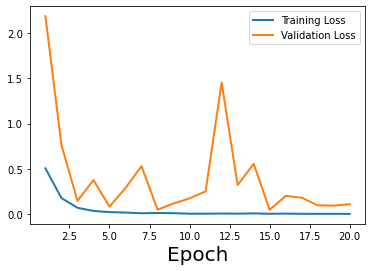

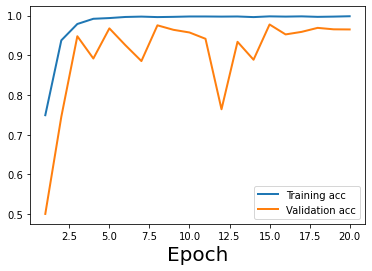

In [ ]:
plot_losses(loss_arr_train, loss_arr_val)
met_list = ['acc']
plot_other_metrics(total_train_metrics, total_val_metrics, met_list)

## Further analysis

#### Things to play with
1. Accuracy, recall, F-1 score, etc. for each class
2. A few test examples comparing truth to prediction
3. Saliency maps (or other) for a few examples
4. How random and evenly distributed are my training vs validation vs test sets?

5. Do I achieve similar results using magnetic energy density or Alfven speed instead? 


In [ ]:
# load the saved model
model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)

model.load_state_dict(torch.load(config.run_name+'_checkpoint.pt',map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=2, bias=Tr

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

classes = config.fileDirArr

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

y_pred = []
y_true = []

# again no gradients needed
with torch.no_grad():
    #for images, labels in train_dl:
    for images, labels in valid_dl:  # use validation set here and for saliency maps
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

        y_pred.extend(predictions) # save the prediction
        y_true.extend(labels) # save the truth


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Validation accuracy for class: {classname:5s} is {accuracy:.1f}')
    print(f'Total predictions for class: {classname:5s} is {total_pred[classname]:.1f}')


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation accuracy for class: MHD_beta10 is 93.5
Total predictions for class: MHD_beta10 is 1638.0
Validation accuracy for class: CR_Diff_Fiducial_beta10 is 99.6
Total predictions for class: CR_Diff_Fiducial_beta10 is 1638.0


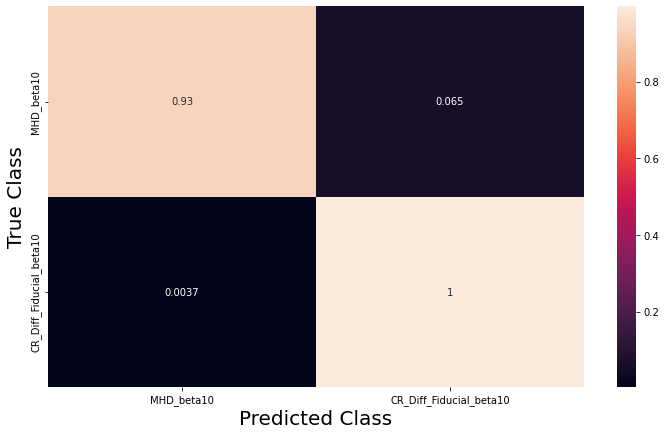

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("Predicted Class",fontsize=20)
plt.ylabel("True Class",fontsize=20)
plt.show()

Let's try to see what the network is picking up on...

## Interpreting the network (Under construction)

In [ ]:
# Try to make a saliency map
# 1. Need to load in an image from one of the data sets
# 2. Evaluate the image with gradients on
# 3. Run backpropagation and store the gradients
# 4. Map the gradients to individual pixels
# 5. Show image
import cmasher as cmr
import random

def saliency(image,label):
  model.eval() # put in evaluation mode

  # requires a 4D tensor, so need to reshape this 3D one
  image = image.reshape(1, 1, image.shape[1], image.shape[2])


  # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
  image.requires_grad_()

  # run the model on the image
  outputs = model(image)

  # Get the index corresponding to the maximum score and the maximum score itself.
  pred_max_index = outputs.argmax()
  pred_max = outputs[0,pred_max_index]

  # backward pass to calculate the gradient
  pred_max.backward()

  saliency, _ = torch.max(image.grad[0].data.abs(),dim=0) # dim = 0 is channel?
  
  # renormalize saliency
  saliency = (saliency - saliency.min())/(saliency.max()-saliency.min())

  # code to plot the saliency map as a heatmap
  plt_image = image.reshape(image.shape[2],image.shape[3])
  #saliency = saliency.reshape(image.shape[2],image.shape[3])
  plt_image = plt_image.detach().numpy()

  # Blur the saliency maps using a gaussian kernel and then overplot contours on the original image
  from scipy.ndimage.filters import gaussian_filter

  filtered_saliency = gaussian_filter(saliency,sigma=4.0)

  return plt_image, filtered_saliency

In [ ]:
# custom function to conduct occlusion experiments
# largely taken from: 
# https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):
    image = image.reshape(1, 1, image.shape[1], image.shape[2])
    #image[:,:,:,:] = occ_pixel

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))

    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1) # makes it a probability for each class?
            #print(output)
            prob = output.tolist()[0][label]
            #print(prob)
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-16-9c09b0c1cb95>:41: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


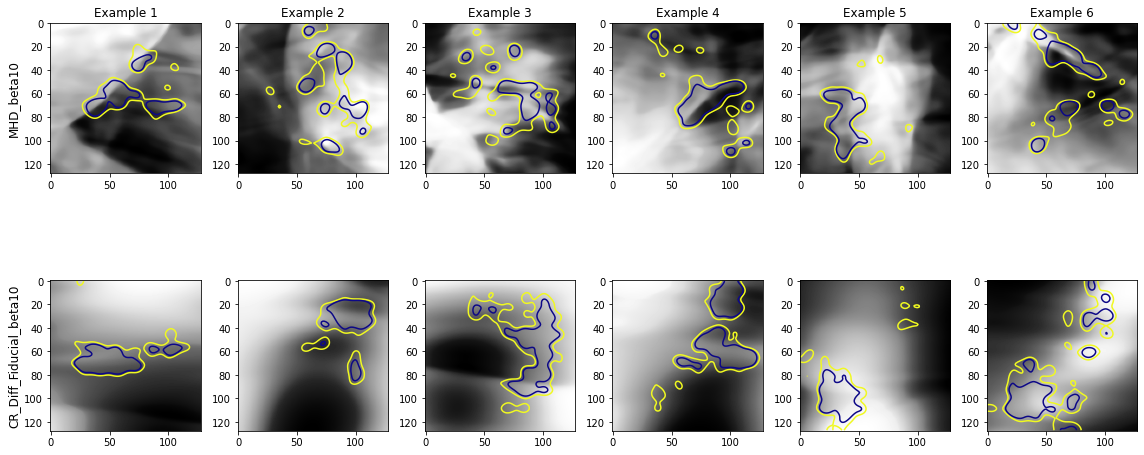

In [ ]:
# Saliency

n_examples = 6 # number of columns
n_classes = 2 # number of rows

fig, axs = plt.subplots(n_classes, n_examples, figsize=(16,8))
ctr = np.zeros(len(config.fileDirArr))

# access a batch of labelled images
dataiter = iter(valid_dl)
images, labels = next(dataiter)

# select n_example example images from each class
for i in range(0,n_classes):
  images_to_plot = images[labels==i]
  for j in range(0,n_examples):
    plt_image, filtered_saliency = saliency(images_to_plot[j],i)
    # normalize the saliency by its max and plot only one or two levels in the middle range
    filtered_saliency = filtered_saliency/np.max(filtered_saliency)
    axs[i,j].imshow(plt_image,cmap='gray')
    axs[i,j].contour(filtered_saliency,cmap='plasma_r', levels=[0.5, 0.6], linewidths = 1.5)

cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
rows = config.fileDirArr

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
#fig.suptitle("beta = 100 class")
#fig.suptitle(f'Ground truth: {classes[label]}')
plt.show()

IndexError: ignored

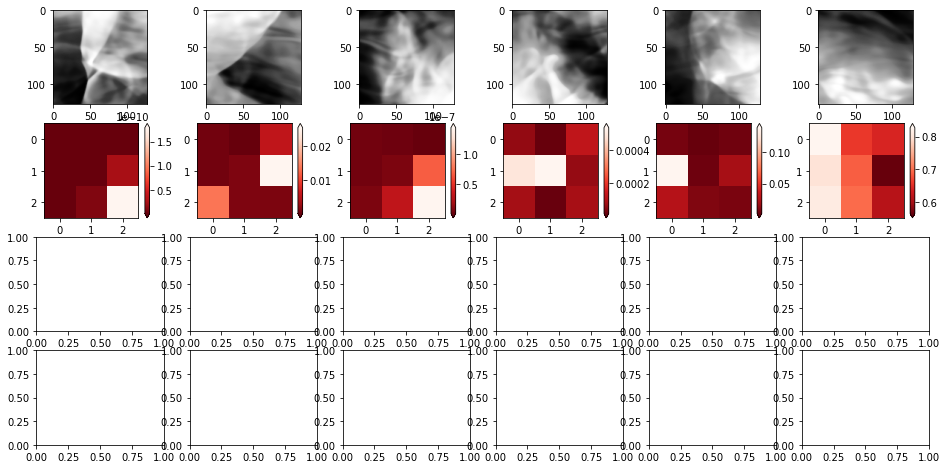

In [ ]:
# Occlusion
n_examples = 6 # number of columns
n_classes = 2 # number of rows

fig, axs = plt.subplots(n_classes*2, n_examples, figsize=(16,8))
ctr = np.zeros(len(config.fileDirArr))

# access a batch of labelled images
dataiter = iter(valid_dl)
images, labels = next(dataiter)

# select n_example example images from each class
for i in range(0,n_classes):
  images_to_plot = images[labels==i]
  for j in range(0,n_examples):
    plt_image = images_to_plot[j,:,:,:]

    #plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=10.0))
    probs = occlusion(model, plt_image, 1, occ_size = 32, occ_stride = 32, occ_pixel = 0.5)
    plt_image = plt_image.squeeze()
    # normalize the saliency by its max and plot only one or two levels in the middle range
    #filtered_saliency = filtered_saliency/np.max(filtered_saliency)
    axs[2*i,j].imshow(plt_image,cmap='gray')
    #axs[i,j].imshow(probs,cmap='plasma_r', levels=[0.6], linewidths = 2)
    heatmap = axs[2*i+1,j].imshow(probs, cmap='Reds_r',vmin = probs.min(), vmax = probs.max())
    color_bar = fig.colorbar(heatmap, 
                         ax = axs[2*i+1,j],
                         extend = 'both')


cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
rows = config.fileDirArr

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large')

fig.tight_layout()
#fig.suptitle("beta = 100 class")
#fig.suptitle(f'Ground truth: {classes[label]}')
plt.show()

In [ ]:
# Create 1D power spectrum from image

import scipy.stats as stats

def power1D(image):
    image = image.reshape(image.shape[-2],image.shape[-1])
    npix = image.shape[1]
    power = 1.0

    fourier_image = np.fft.fftn(image**power)
    fourier_amplitudes = np.abs(fourier_image)**2

    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)

    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    k = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    return k, Abins

<ipython-input-20-6a650b7022b6>:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


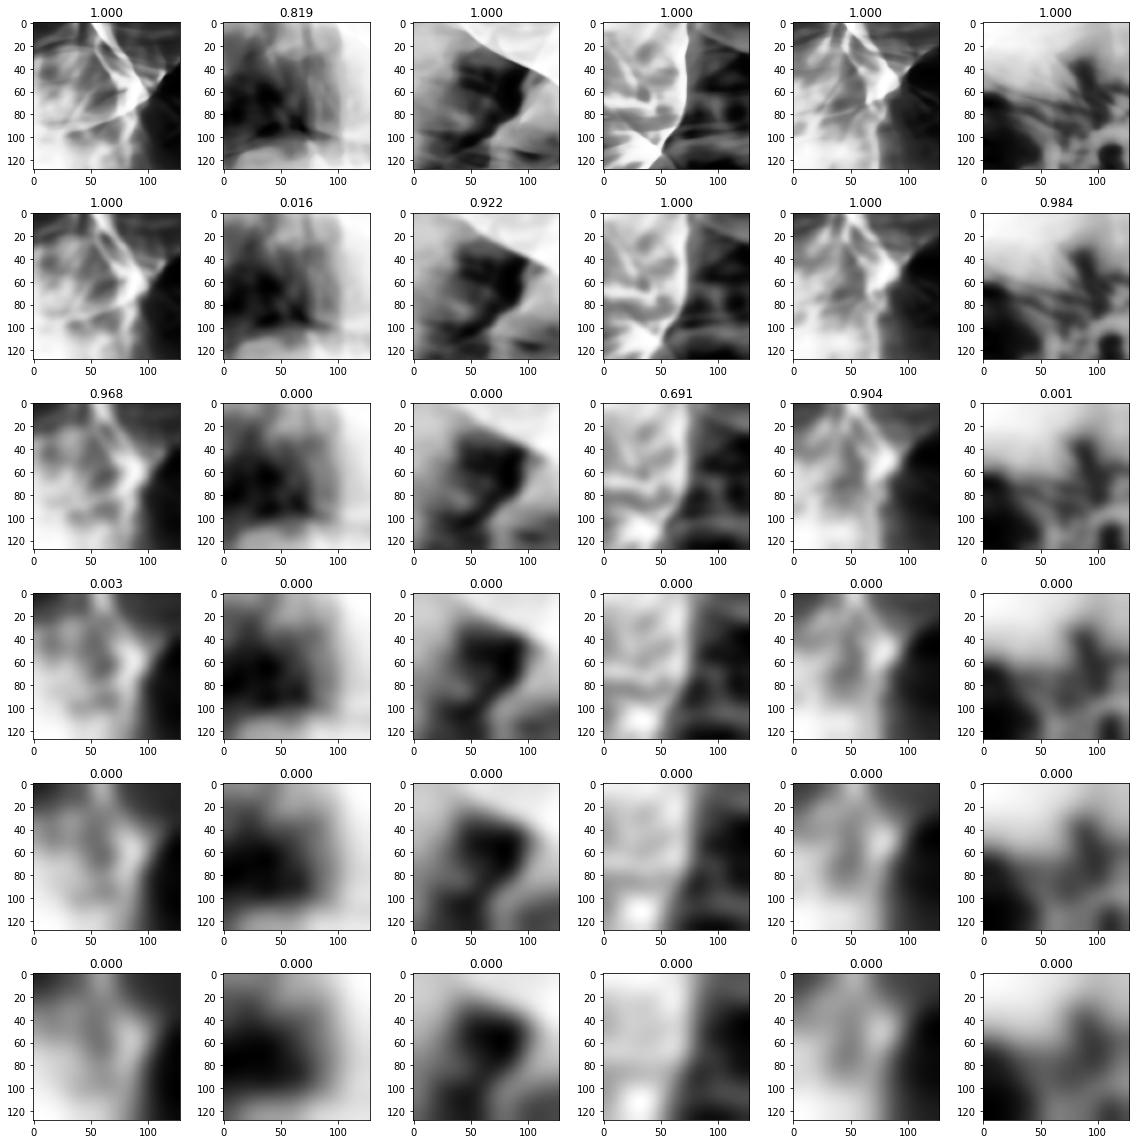

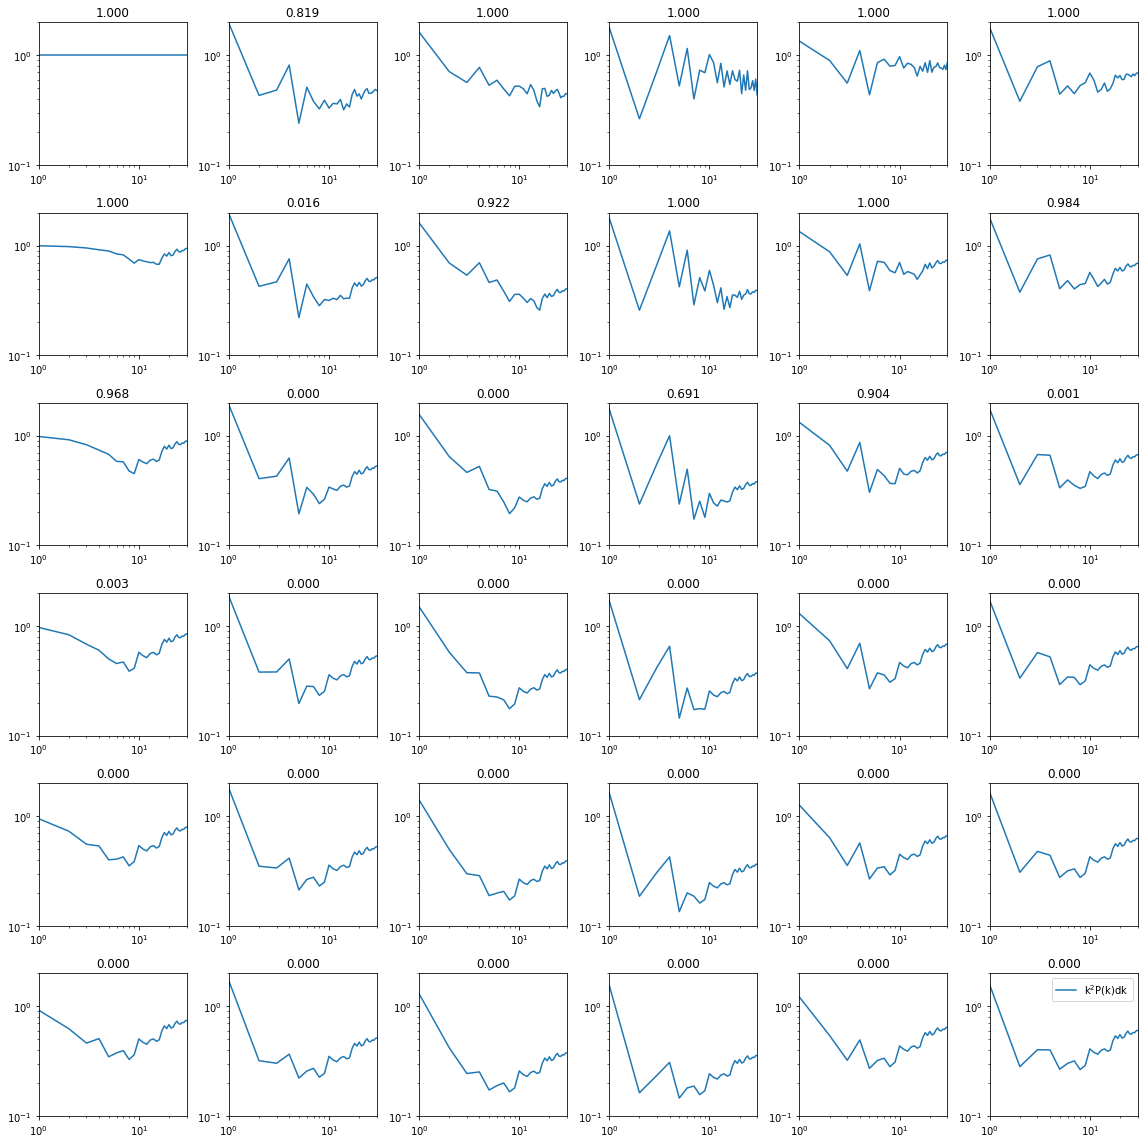

In [ ]:
# gaussian filtering

from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to show probability of
sim_class = 0

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

fig, axs = plt.subplots(n_sigmas, n_examples, figsize=(16,16))
fig_spectra, axs_spectra = plt.subplots(n_sigmas, n_examples, figsize=(16,16))


# access a batch of labelled images
dataiter = iter(valid_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_to_plot = images[labels==0]
k_norm, pwr_norm = power1D(images_to_plot[0,:,:,:])
for i in range(0,n_sigmas):
  for j in range(0,n_examples):
    plt_image = images_to_plot[j,:,:,:]
    
    # apply a Gaussian filter with standard deviation sigma to the image
    plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

    # create 1D power spectrum of filtered image
    k, pwr = power1D(plt_image)
    
    #run inference on modified image
    output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
    output = nn.functional.softmax(output, dim=1) # makes it a probability for each class
    
    prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

    axs[i,j].imshow(plt_image.squeeze(),cmap='gray')
    axs[i,j].set_title('{:.3f}'.format(prob))

    axs_spectra[i,j].loglog(k,pwr*(k**2)/(pwr_norm*(k_norm**2)),label=r"k$^{2}$P(k)dk")
    axs_spectra[i,j].set_title('{:.3f}'.format(prob))
    axs_spectra[i,j].set_xlim(1,30)
    axs_spectra[i,j].set_ylim(1.E-1,2.0)

cols = ['Example {}'.format(col) for col in range(1, n_examples+1)]
rows = config.fileDirArr



fig.tight_layout()
fig_spectra.tight_layout()
#fig.suptitle("beta = 100 class")
#fig.suptitle(f'Ground truth: {classes[label]}')
plt.legend()
plt.show()


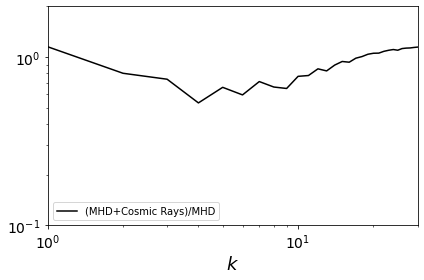

In [ ]:
# Let's plot some average spectra for the two classes

# access a batch of labelled images
dataiter = iter(valid_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_class0 = images[labels==0]
images_class1 = images[labels==1]

pwrvec0 = np.zeros(64)
pwrvec1 = np.zeros(64)

for i in range(0,len(images_class0)):
    plt_image = images_class0[i,:,:,:]
    
    # create 1D power spectrum of filtered image
    kvec, pwr = power1D(plt_image)
    
    pwrvec0 = np.vstack([pwrvec0, pwr]) # does the eigenmode analysis and spits out KE vs k

#a = pwrvec0[1:9,:]  # last few rows (times) of spectrum array

avg0 = np.mean(pwrvec0,axis = 0)
mina0 = avg0-np.std(pwrvec0,axis = 0)
maxa0 = avg0+np.std(pwrvec0,axis = 0)

# do the same for class1
for i in range(0,len(images_class1)):
    plt_image = images_class1[i,:,:,:]
    
    # create 1D power spectrum of filtered image
    kvec, pwr = power1D(plt_image)
    
    pwrvec1 = np.vstack([pwrvec1, pwr]) # does the eigenmode analysis and spits out KE vs k

#a = pwrvec1[1:9,:]  # last few rows (times) of spectrum array

avg1 = np.mean(pwrvec1,axis = 0)
mina1 = avg1-np.std(pwrvec1,axis = 0)
maxa1 = avg1+np.std(pwrvec1,axis = 0)


k = kvec[0:len(avg1)]

plt.loglog((k), avg0*(k**2), 'bo-',label=r"MHD")
plt.fill_between((k), mina0*(k**2), maxa0*(k**2), facecolor='blue', alpha=0.5)
plt.loglog((k), avg1*(k**2), 'go-',label=r"MHD + Cosmic Rays")
plt.fill_between((k), mina1*(k**2), maxa1*(k**2), facecolor='green', alpha=0.5)
#plt.ylim(1E-5,4E-3)
plt.xlim(1,30)
#plt.xlabel(r"$\lambda / L$",fontsize=18)
plt.xlabel(r"$k$",fontsize=18)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("Spectra_byClass.png")
plt.close()

div_std = np.std(pwrvec0,axis = 0) + np.std(pwrvec1,axis = 0)
plt.loglog((k), avg1/avg0, 'k-',label=r"(MHD+Cosmic Rays)/MHD")
#plt.fill_between((k), (avg1/avg0) - div_std/avg0, (avg1/avg0) + div_std/avg0, facecolor='gray', alpha=0.5)
#plt.loglog((k), avg1*(k**2), 'go-',label=r"MHD + Cosmic Rays")
#plt.fill_between((k), mina1*(k**2), maxa1*(k**2), facecolor='green', alpha=0.5)
plt.ylim(1E-1,2)
plt.xlim(1,30)
#plt.xlabel(r"$\lambda / L$",fontsize=18)
plt.xlabel(r"$k$",fontsize=18)
#plt.ylabel(r"k$^{2}$P(k)dk",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()



<ipython-input-26-a2474492c0b5>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


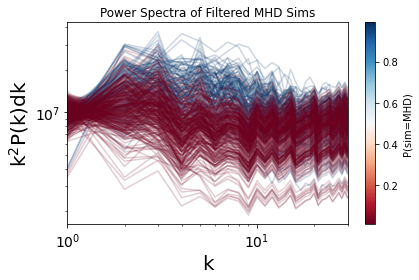

In [ ]:
# make spectra for filtered images and color them by probabilities

import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to calculate probability of
sim_class = 0

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

# access a batch of labelled images
dataiter = iter(valid_dl)
images, labels = next(dataiter)

# select n_example example images from each class
images_class0 = images[labels==0]
images_class1 = images[labels==1]

cvals = np.arange(1.E-2,1.0,1.E-2)
colors = plt.cm.RdBu(cvals)

norm = mpl.colors.Normalize(vmin=cvals.min(), vmax=cvals.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)
cmap.set_array([])

fig, axs = plt.subplots()

for i in range(0,n_sigmas):
  for j in range(0,len(images_class0)):
    plt_image = images_class0[j,:,:,:]
    
    # apply a Gaussian filter with standard deviation sigma to the image
    plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

    # create 1D power spectrum of filtered image
    k, pwr = power1D(plt_image)
    
    #run inference on modified image
    output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
    output = nn.functional.softmax(output, dim=1) # makes it a probability for each class
    
    prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

    axs.loglog(k,pwr*(k**2),label=r"k$^{2}$P(k)dk",color=colors[np.abs(cvals-prob).argmin()],alpha=0.2)
    #plt.ylim(1.E-1,2.0)

plt.xlim(1,30)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=20)
plt.xlabel("k",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Power Spectra of Filtered MHD Sims")
fig.colorbar(cmap,label="P(sim=MHD)")

plt.tight_layout()
#plt.legend()
#plt.savefig("Prob_Filtered_Spectra.png",dpi=600)
#plt.close()
plt.show()

These saliency maps are showing me almost nothing. Next step could be to play with Grad-cam, which I've started on but run into problems using grayscale images instead of RGB images


In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=5220af80bcd5f87d96f5b81501cd44a03fe50afcffbc86d83911e532b07c381c
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
# taken straight from this link for now: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

#print(model.children)
#target
#target_layers = [model.children()[0]]
# how do you access layers from nn.Sequential??

target_layers = [model[-4]]

dataiter = iter(train_dl)
images, labels = next(dataiter)
img = images[0,:,:,:].numpy()
gray_img_float = np.float32(img) / 255

input_tensor = torch.from_numpy(gray_img_float).reshape(1,1,128,128)

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

#targets = [ClassifierOutputTarget(1)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
#grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(gray_img_float, grayscale_cam[0,:], use_rgb=True)

ValueError: ignored

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(281)
scores, batch_visualizations = CamMultImageConfidenceChange()(input_tensor, 
  inverse_cams, targets, model, return_visualization=True)
visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, perturbation_visualizations = cam_metric(input_tensor, 
  grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,
                                          ROADLeastRelevantFirstAverage,
                                          ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)